
# **3D Spleen Segmentation**
This notebook contains the code of the paper "Evaluation of a Deep Learning Algorithm for Automated Spleen Segmentation in Patients with Conditions Directly or Indirectly Affecting the Spleen" published in
Tomography 2021, 7(4), 950-960; https://doi.org/10.3390/tomography7040078


**Setup environment**

In [ ]:
#%pip uninstall monai--weekly
%pip install monai==0.5.0
%pip install 'monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil]'
%pip install matplotlib
#%pip install -q pytorch-lightning
%pip install pytorch-lightning
%matplotlib inline

**Setup imports**

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Lambda,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    LabelToContour,
    KeepLargestConnectedComponent,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice, compute_roc_auc
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, NiftiSaver
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint \
    import ModelCheckpoint
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import sys
from glob import glob
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 



print_config()

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


MONAI version: 0.5.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2707407fed8c78ccb1c18d1e994a68580457219e

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: 5.1.2
tqdm version: 4.61.2
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
data_dir= "Data"


**Define the LightningModule**

The LightningModule contains a refactoring of your training code.

In [ ]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        
        
    ).to(device)
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
        self.post_label = AsDiscrete(to_onehot=True, n_classes=2)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(
            glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(
            glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[9:], data_dicts[:9]

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="PLI"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from
                # big image based on pos / neg ratio
                # the image centers of negative samples
                # must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # user can also add other random transforms
                #                 RandAffined(
                #                     keys=['image', 'label'],
                #                     mode=('bilinear', 'nearest'),
                #                     prob=1.0,
                #                     spatial_size=(96, 96, 96),
                #                     rotate_range=(0, 0, np.pi/15),
                #                     scale_range=(0.1, 0.1, 0.1)),
                ToTensord(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="PLI"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files, transform=train_transforms,
            cache_rate=1.0, num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
#         self.train_ds = monai.data.Dataset(
#             data=train_files, transform=train_transforms)
#         self.val_ds = monai.data.Dataset(
#             data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True,
            num_workers=4, collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = self.post_pred(outputs)
        labels = self.post_label(labels)
        value = compute_meandice(
            y_pred=outputs,
            y=labels,
            include_background=False,
        )
        return {"val_loss": loss, "val_dice": value}

    def validation_epoch_end(self, outputs):
        val_dice, val_loss, num_items = 0, 0, 0
        for output in outputs:
            val_dice += output["val_dice"].sum().item()
            val_loss += output["val_loss"].sum().item()
            num_items += len(output["val_dice"])
        mean_val_dice = torch.tensor(val_dice / num_items)
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
            torch.save(self._model.state_dict(), "/content/drive/My Drive/Spleen_AI/best_metric_model_deca_20.pth")
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

In [ ]:
import nibabel as nib
train_images = sorted(
            glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
            glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
for i in train_images:
  img = nib.load(i)
  print("images", img.shape)
for i in train_labels:
  img = nib.load(i)
  print("labels", img.shape)

**Run the training**

In [ ]:
root_dir = "/content/drive/My Drive/Spleen_AI/CH Data"
device = torch.device("cuda:0")

# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(dirpath= os.path.join(
        log_dir, "{epoch}-{val_loss:.2f}-{val_dice:.2f}")
)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=20,
    logger=tb_logger,
    checkpoint_callback=checkpoint_callback,
    num_sanity_val_steps=1,
)

# train
trainer.fit(net)

In [ ]:
print(
    f"train completed, best_metric: {net.best_val_dice:.4f} "
    f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.9490 at epoch 263


**Check best model output with the input image and label**

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


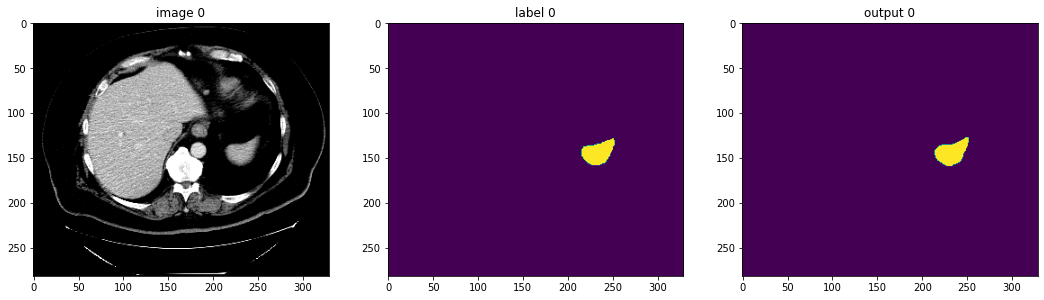

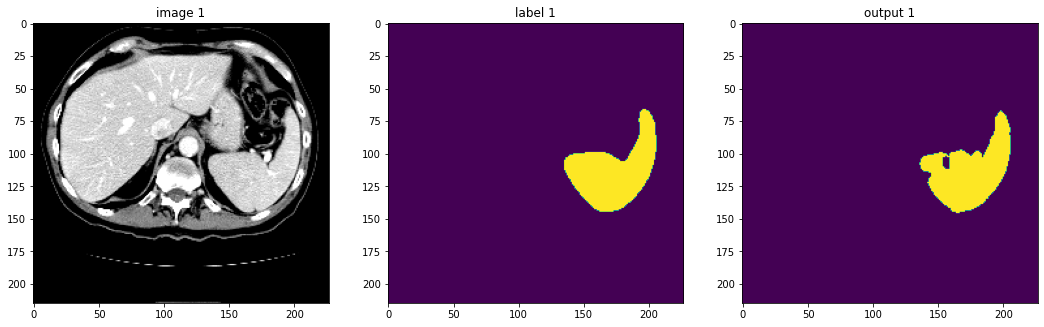

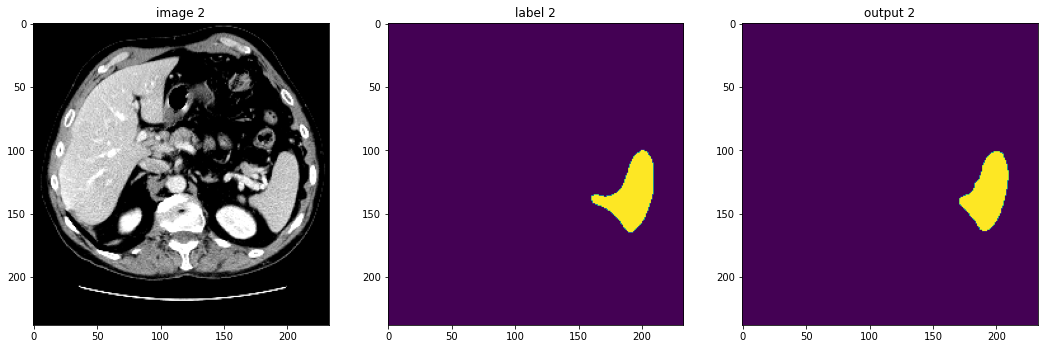

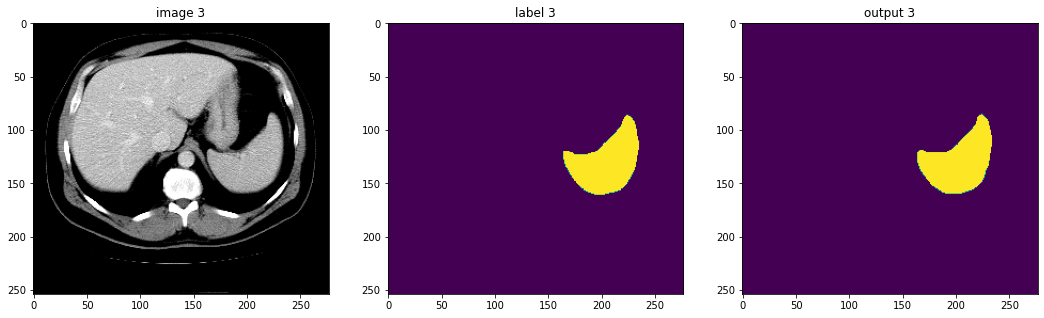

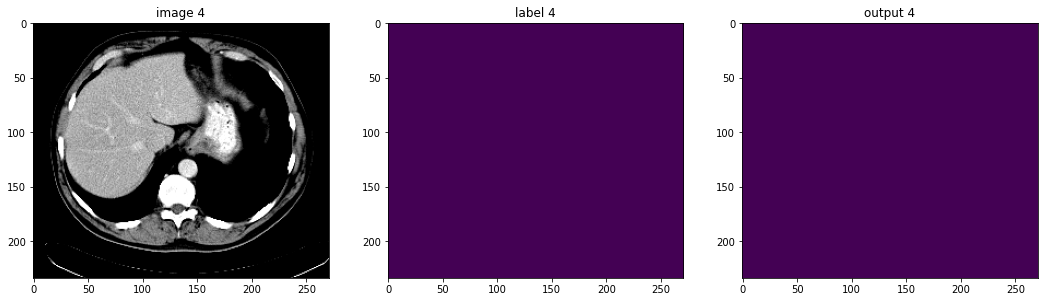

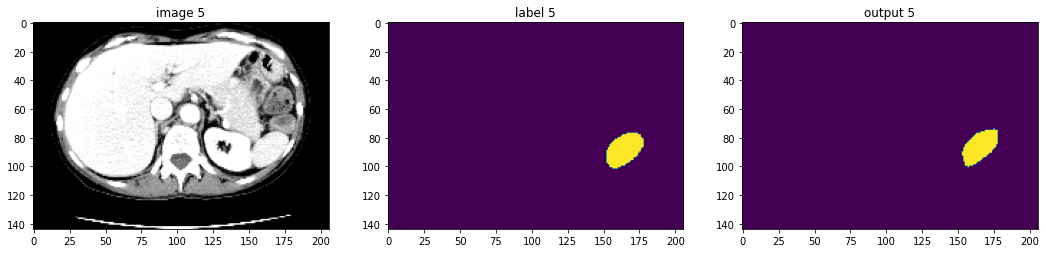

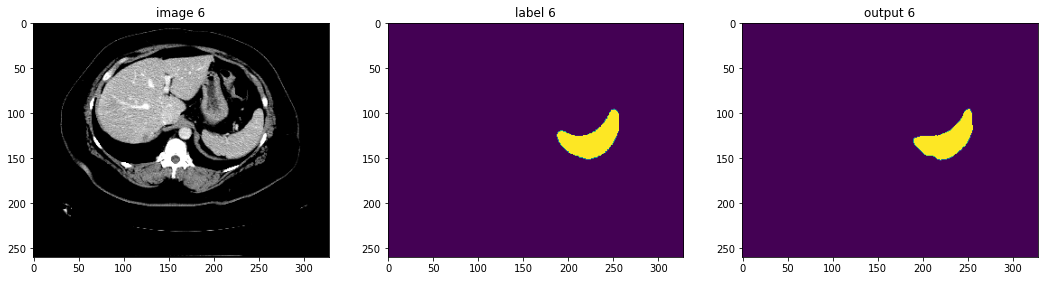

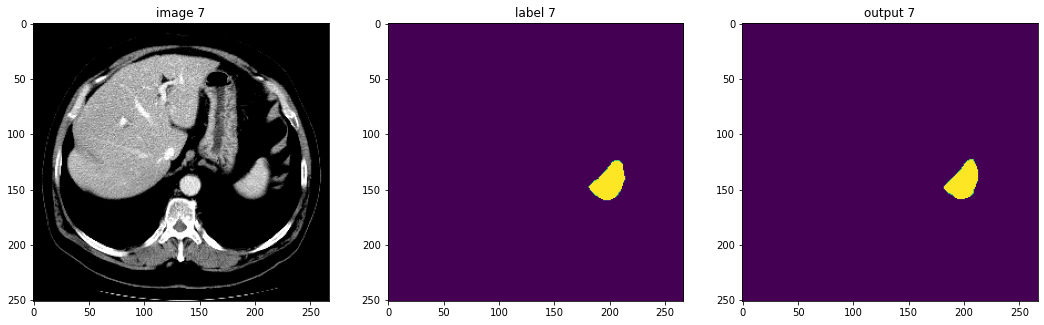

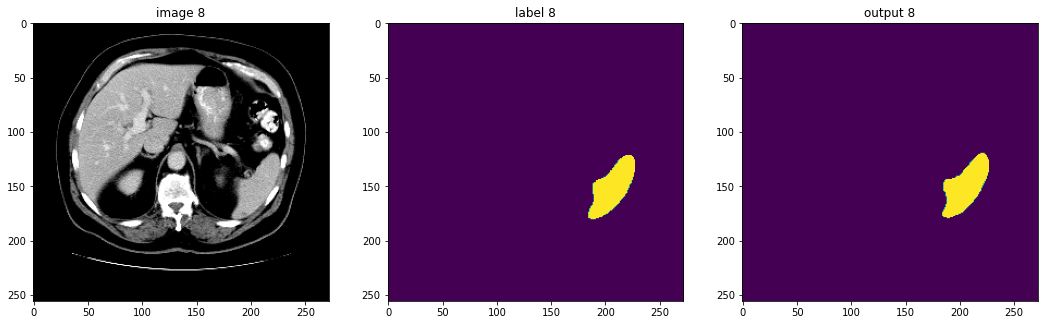

In [ ]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 40], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 40])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 40])
        plt.show()

**Evaluation with Inhouse Dataset**

In [ ]:
eval_dir= "CH_Data"

images = sorted(glob(os.path.join(eval_dir, "imagesTs", "*.nii.gz")))
labels = sorted(glob(os.path.join(eval_dir, "labelsTs", "*.nii.gz")))
test = [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, labels)]
val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="PLI"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        ) 
val_ds = CacheDataset(
            data=test, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=2)
from monai.metrics import DiceMetric
from monai.transforms import Activations, AddChannel, AsDiscrete, Compose, ScaleIntensity, ToTensor
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True), KeepLargestConnectedComponent(applied_labels=[1])])



Loading dataset: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


val_dice: tensor([[0.8943]], device='cuda:0')
Hausdorff: tensor([[5.]], dtype=torch.float64)
Shape: torch.Size([1, 1, 208, 243, 254])
Volume: [tensor(61722, device='cuda:0')] mm3


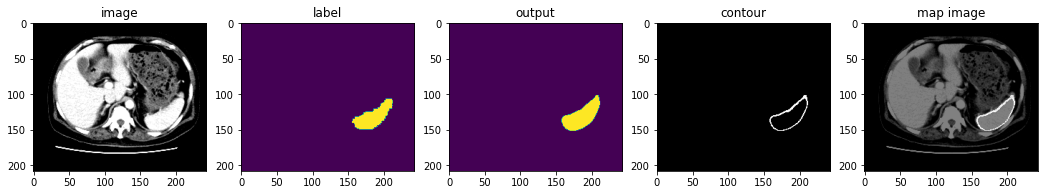

val_dice: tensor([[0.9506]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 257, 301, 241])
Volume: [tensor(72541, device='cuda:0')] mm3


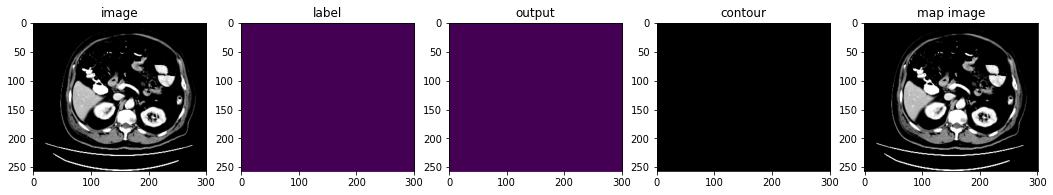

val_dice: tensor([[0.8952]], device='cuda:0')
Hausdorff: tensor([[13.7477]], dtype=torch.float64)
Shape: torch.Size([1, 1, 251, 303, 234])
Volume: [tensor(70902, device='cuda:0')] mm3


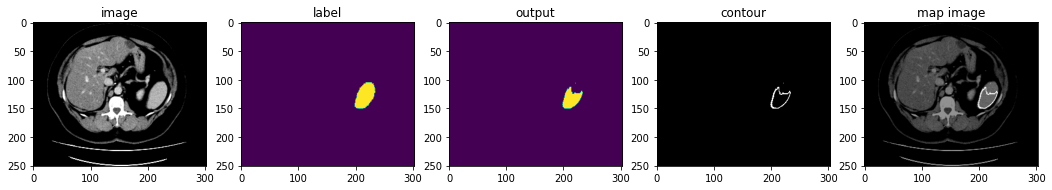

val_dice: tensor([[0.9412]], device='cuda:0')
Hausdorff: tensor([[2.4495]], dtype=torch.float64)
Shape: torch.Size([1, 1, 208, 247, 214])
Volume: [tensor(52858, device='cuda:0')] mm3


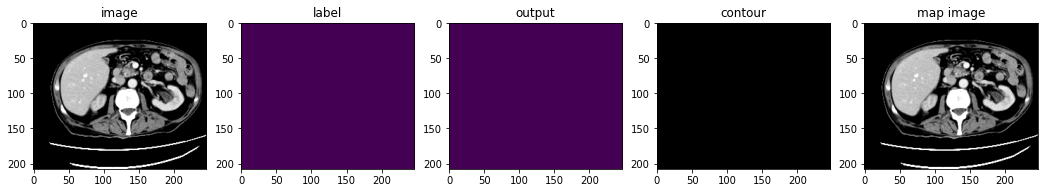

val_dice: tensor([[0.9638]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 191, 241, 231])
Volume: [tensor(55671, device='cuda:0')] mm3


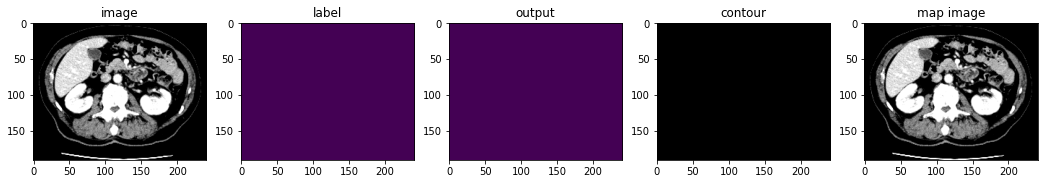

val_dice: tensor([[0.9476]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 206, 239, 241])
Volume: [tensor(57599, device='cuda:0')] mm3


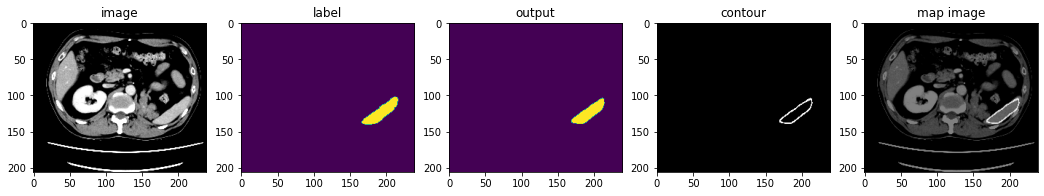

val_dice: tensor([[0.9566]], device='cuda:0')
Hausdorff: tensor([[5.9161]], dtype=torch.float64)
Shape: torch.Size([1, 1, 209, 252, 341])
Volume: [tensor(85932, device='cuda:0')] mm3


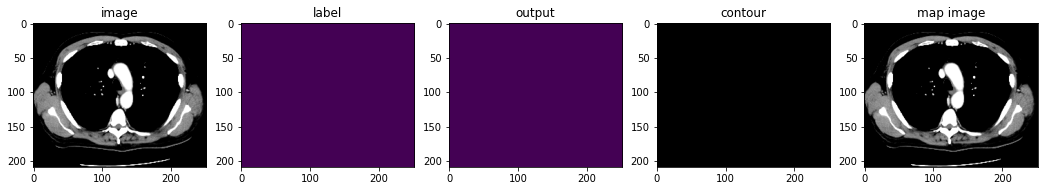

val_dice: tensor([[0.9097]], device='cuda:0')
Hausdorff: tensor([[11.2250]], dtype=torch.float64)
Shape: torch.Size([1, 1, 222, 302, 296])
Volume: [tensor(89392, device='cuda:0')] mm3


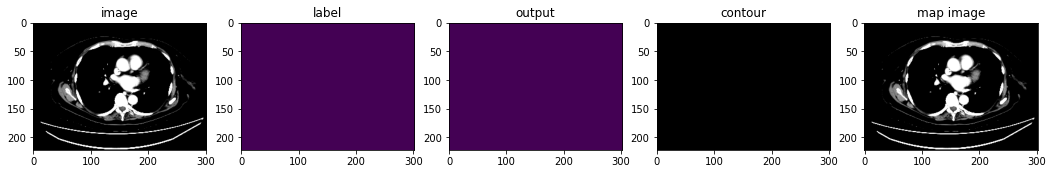

val_dice: tensor([[0.9535]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 197, 264, 384])
Volume: [tensor(101376, device='cuda:0')] mm3


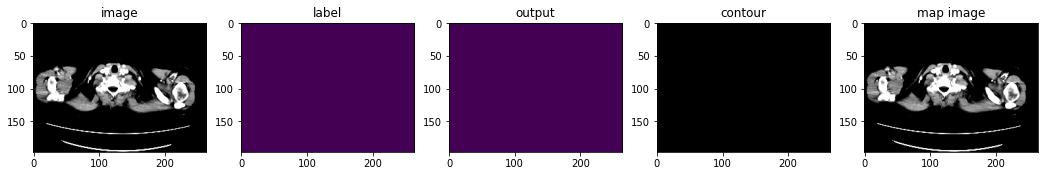

val_dice: tensor([[0.9528]], device='cuda:0')
Hausdorff: tensor([[3.7417]], dtype=torch.float64)
Shape: torch.Size([1, 1, 203, 253, 246])
Volume: [tensor(62238, device='cuda:0')] mm3


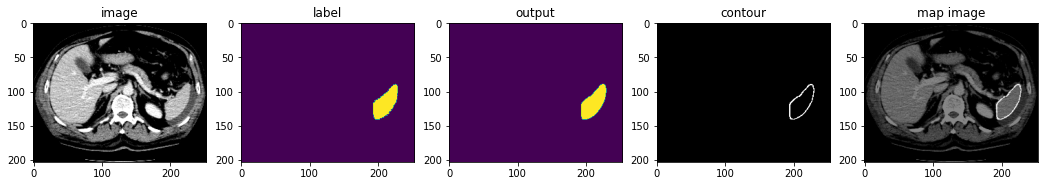

val_dice: tensor([[0.9583]], device='cuda:0')
Hausdorff: tensor([[3.3166]], dtype=torch.float64)
Shape: torch.Size([1, 1, 222, 250, 216])
Volume: [tensor(54000, device='cuda:0')] mm3


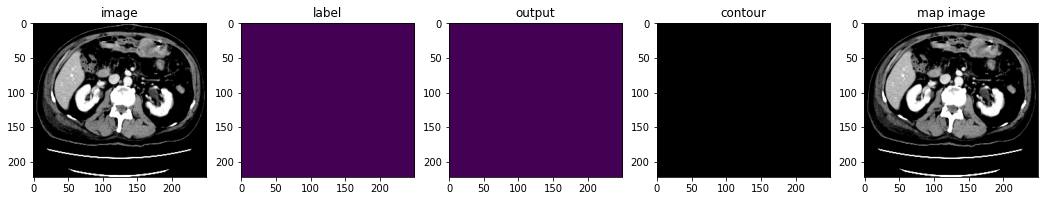

val_dice: tensor([[0.9515]], device='cuda:0')
Hausdorff: tensor([[5.0990]], dtype=torch.float64)
Shape: torch.Size([1, 1, 114, 217, 300])
Volume: [tensor(65100, device='cuda:0')] mm3


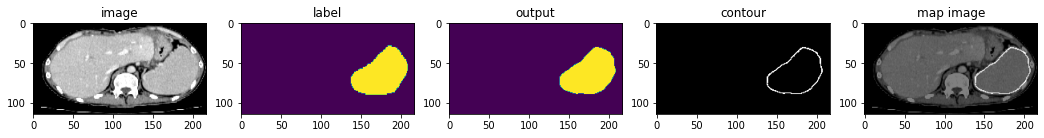

val_dice: tensor([[0.9380]], device='cuda:0')
Hausdorff: tensor([[5.0990]], dtype=torch.float64)
Shape: torch.Size([1, 1, 225, 255, 224])
Volume: [tensor(57120, device='cuda:0')] mm3


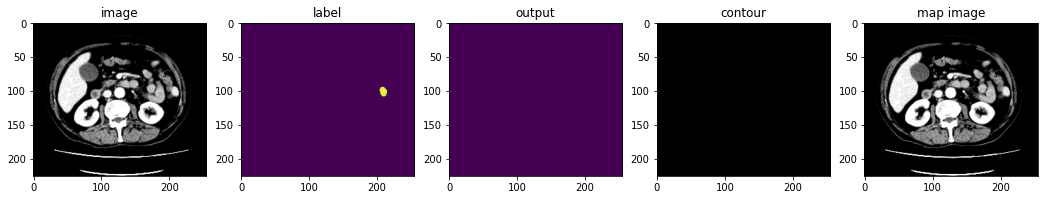

val_dice: tensor([[0.9235]], device='cuda:0')
Hausdorff: tensor([[6.1644]], dtype=torch.float64)
Shape: torch.Size([1, 1, 193, 278, 231])
Volume: [tensor(64218, device='cuda:0')] mm3


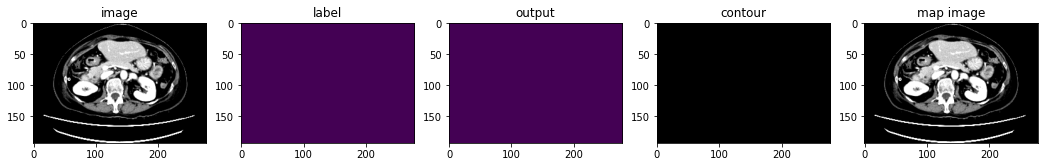

val_dice: tensor([[0.9682]], device='cuda:0')
Hausdorff: tensor([[6.7082]], dtype=torch.float64)
Shape: torch.Size([1, 1, 228, 251, 234])
Volume: [tensor(58734, device='cuda:0')] mm3


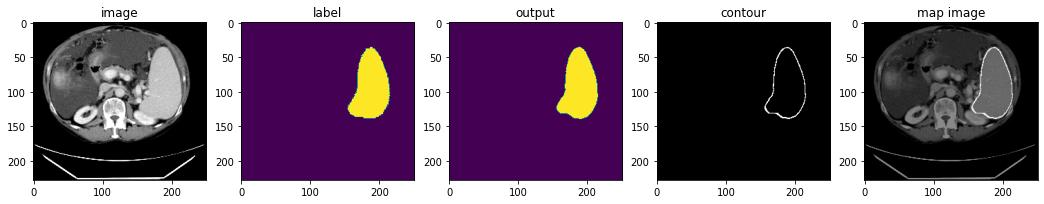

val_dice: tensor([[0.9548]], device='cuda:0')
Hausdorff: tensor([[7.]], dtype=torch.float64)
Shape: torch.Size([1, 1, 211, 252, 278])
Volume: [tensor(70056, device='cuda:0')] mm3


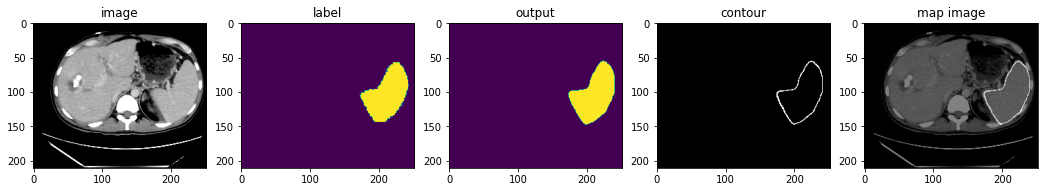

val_dice: tensor([[0.9530]], device='cuda:0')
Hausdorff: tensor([[5.7446]], dtype=torch.float64)
Shape: torch.Size([1, 1, 194, 240, 238])
Volume: [tensor(57120, device='cuda:0')] mm3


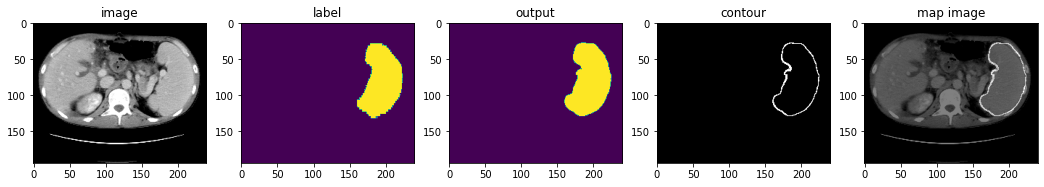

val_dice: tensor([[0.9300]], device='cuda:0')
Hausdorff: tensor([[19.8746]], dtype=torch.float64)
Shape: torch.Size([1, 1, 250, 262, 316])
Volume: [tensor(82792, device='cuda:0')] mm3


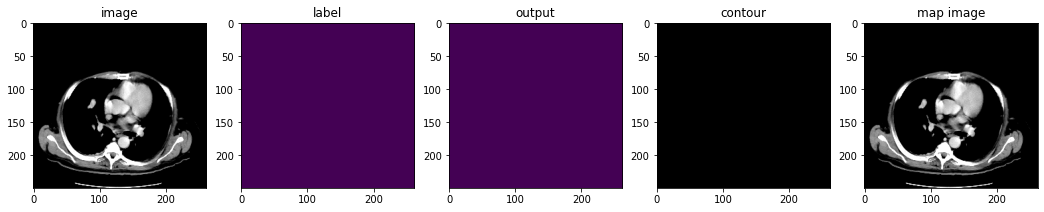

val_dice: tensor([[0.9473]], device='cuda:0')
Hausdorff: tensor([[7.3485]], dtype=torch.float64)
Shape: torch.Size([1, 1, 182, 241, 218])
Volume: [tensor(52538, device='cuda:0')] mm3


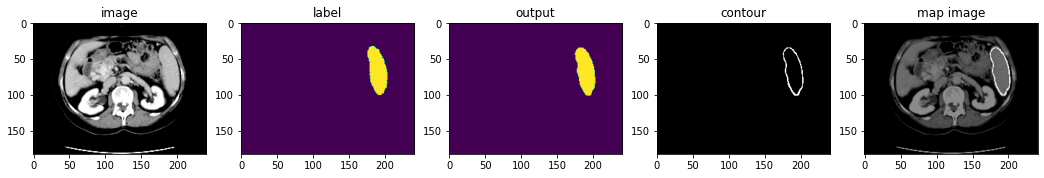

val_dice: tensor([[0.9386]], device='cuda:0')
Hausdorff: tensor([[21.6564]], dtype=torch.float64)
Shape: torch.Size([1, 1, 187, 218, 211])
Volume: [tensor(45998, device='cuda:0')] mm3


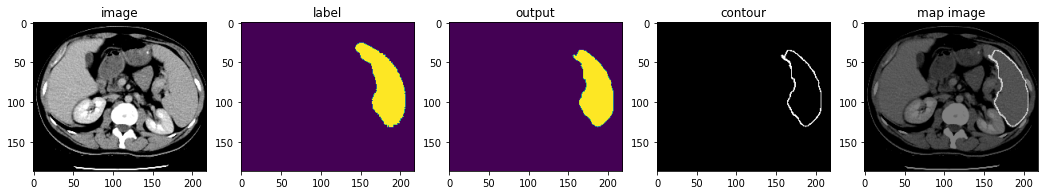

evaluation metric: 0.9414289832115174


In [ ]:
from monai.metrics import get_confusion_matrix, compute_hausdorff_distance
device = torch.device("cuda:0")
model =     UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            ).to(device)
#loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
device = torch.device("cuda:0")
model.load_state_dict(torch.load("/content/drive/My Drive/Spleen_AI/best_metric_model_ch_500.pth"))
model.eval()
model.to(device)
with torch.no_grad():
        metric_sum = 0.0
        metric_count = 0
        saver = NiftiSaver(output_dir="/content/drive/My Drive/Spleen_AI/CH Data/mask")
        for val_data in val_loader:
            # define sliding window size and batch size for windows inference
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            val_outputs = post_trans(val_outputs)
            shape=val_images.shape
            vols = [(b[:,1]==1).sum() for b in val_outputs]
            vol_label = [(x==1).sum() for x in val_labels]
            value = compute_meandice(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False)
          
            conf = get_confusion_matrix(y_pred=val_outputs, y=val_labels, include_background=False)
            hausdorff = compute_hausdorff_distance(y_pred=val_outputs, y=val_labels, include_background=False)
            metric_count += len(value)
            metric_sum += value.item() * len(value)
            #print(f"val_loss:", loss)
            print(f"val_dice:", value)
            #print(f"Confusion Matrix:", conf)
            print(f"Hausdorff:",hausdorff)
            print(f"Shape:", shape)
            print(f"Volume:", vols, f"mm3")
            #print(f"y_pred:",val_outputs)
            #print(f"y:", val_labels)
            
            plt.figure("check", (18, 6))
            plt.subplot(1, 5, 1)
            plt.title(f"image")
            plt.imshow(val_data["image"][0, 0, :, :, 65], cmap="gray")
            plt.subplot(1, 5, 2)
            plt.title(f"label")
            plt.imshow(val_data["label"][0, 0, :, :, 65])
            plt.subplot(1, 5, 3)
            plt.title(f"output")
            plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 65])
            plt.subplot(1, 5, 4)
            plt.title(f"contour")
            argmax = AsDiscrete(argmax=True)(val_outputs)
            largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
            contour = LabelToContour()(largest) 
            plt.imshow(contour.detach().cpu()[0, 0, :, :, 65],cmap="gray")
            plt.subplot(1, 5, 5)
            plt.title(f"map image")
            map_image = contour + val_images
            plt.imshow(map_image.detach().cpu()[0, 0, :, :, 65], cmap="gray")
            plt.show()
            saver.save_batch(val_outputs[:, 0, ...  ], val_data["image_meta_dict"])
        metric = metric_sum / metric_count
        print("evaluation metric:", metric)

In [ ]:
from monai.metrics import get_confusion_matrix, compute_hausdorff_distance
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

device = torch.device("cuda:0")
model =     UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            ).to(device)
#loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
device = torch.device("cuda:0")
model.load_state_dict(torch.load("/content/drive/My Drive/Spleen_AI/best_metric_model_ch_200.pth"))
model.eval()
model.to(device)
with torch.no_grad():
        metric_sum = 0.0
        metric_count = 0
        #saver = NiftiSaver(output_dir="./output")
        
        report= pd.DataFrame()
        #saver = CSVSaver(output_dir="/content/drive/My Drive/Task09_Spleen/metrics")
        for val_data in val_loader:
          for i in enumerate (val_loader):
            # define sliding window size and batch size for windows inference
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            val_outputs = post_trans(val_outputs)
            shape=val_images.shape
            vols = [(b[:,1]==1).sum() for b in val_outputs]
            vol_label = [(x==1).sum() for x in val_labels]
      
            print(type(vols))
            
            value = compute_meandice(y_pred=val_outputs, y=val_labels,include_background=False)
            hausdorff = compute_hausdorff_distance(y_pred=val_outputs, y=val_labels, include_background=False)
            metric_count += len(value)
            metric_sum += value.item() * len(value)
            report = report.append({'Volume label': vols, 'Volume segmentation': vol_label, 'Dice': value.item(), 'hausdorff': hausdorff.item()}, ignore_index=True)
            print(f"shape:", shape)
            print(f"val_dice:", value[0])
            #print(f"Confusion Matrix:", conf)
            print(f"Hausdorff:",hausdorff[0])
            print(f"Volume segmentation:", vols)
            print(f"Volume label:", vol_label)
            #print(f"y_pred:",val_outputs)
            #print(f"y:", val_labels)
            #saver.save_batch(val_outputs, val_data[2])
            #print(type(vols))
            #data.append(vols, hausdorff, value,val_data["image"]) 
            
            # plot the slice [:, :, 80]
            plt.figure("check", (20, 4))
            plt.subplot(1, 5, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data['image'][0, 0, :, :, 80], cmap="gray")
            plt.subplot(1, 5, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, 80])
            plt.subplot(1, 5, 3)
            plt.title(f"output {i}")
            argmax = [AsDiscrete(argmax=True)(i) for i in decollate_batch(val_outputs)]
            plt.imshow(argmax[0].detach().cpu()[0, :, :, 80])
            #plt.subplot(1, 5, 3)
            #plt.title(f"largest {i}")
            largest = [KeepLargestConnectedComponent(applied_labels=[1])(i) for i in argmax]
            #plt.imshow(largest[0].detach().cpu()[0, :, :, 80])
            plt.subplot(1, 5, 4)
            plt.title(f"contour {i}")
            contour = [LabelToContour()(i) for i in largest]
            plt.imshow(contour[0].detach().cpu()[0, :, :, 80])
            plt.subplot(1, 5, 5)
            plt.title(f"map image {i}")
            map_image = contour[0] + val_data[0]
            plt.imshow(map_image.detach().cpu()[0, :, :, 80], cmap="gray")
            plt.show()


          
            
        metric = metric_sum / metric_count
        print("evaluation metric:", metric)
        print("Metrics", report, sep='\n')
        
    

**Evaluation with Decathlon Dataset**

In [ ]:
eval_dir= "/content/drive/My Drive/Task09_Spleen/Decathlon Data"

images = sorted(glob(os.path.join(eval_dir, "imagesTs", "*.nii.gz")))
labels = sorted(glob(os.path.join(eval_dir, "labelsTs", "*.nii.gz")))
test = [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, labels)]
val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="PLI"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        ) 
val_ds = CacheDataset(
            data=test, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=2)
from monai.metrics import DiceMetric
from monai.transforms import Activations, AddChannel, AsDiscrete, Compose, ScaleIntensity, ToTensor
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True), KeepLargestConnectedComponent(applied_labels=[1])])



Loading dataset: 100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


val_dice: tensor([[0.8943]], device='cuda:0')
Hausdorff: tensor([[5.]], dtype=torch.float64)
Shape: torch.Size([1, 1, 208, 243, 254])
Volume: [tensor(61722, device='cuda:0')] mm3


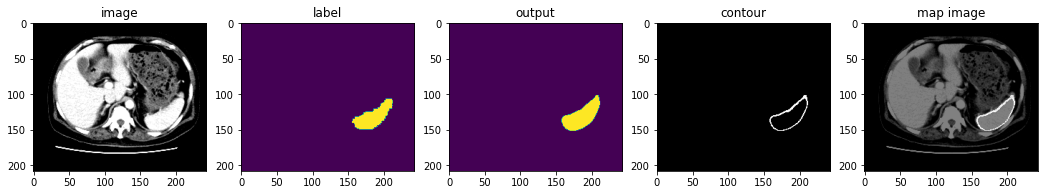

val_dice: tensor([[0.9506]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 257, 301, 241])
Volume: [tensor(72541, device='cuda:0')] mm3


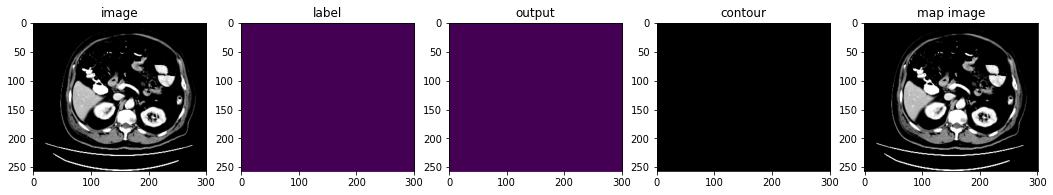

val_dice: tensor([[0.8952]], device='cuda:0')
Hausdorff: tensor([[13.7477]], dtype=torch.float64)
Shape: torch.Size([1, 1, 251, 303, 234])
Volume: [tensor(70902, device='cuda:0')] mm3


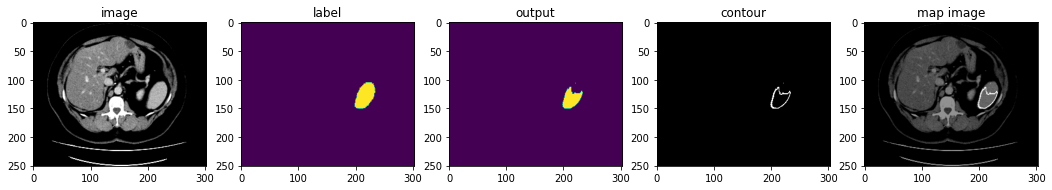

val_dice: tensor([[0.9412]], device='cuda:0')
Hausdorff: tensor([[2.4495]], dtype=torch.float64)
Shape: torch.Size([1, 1, 208, 247, 214])
Volume: [tensor(52858, device='cuda:0')] mm3


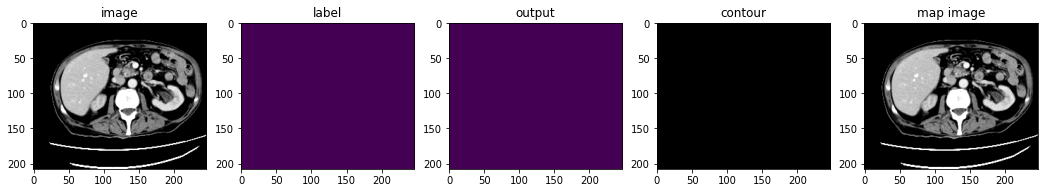

val_dice: tensor([[0.9638]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 191, 241, 231])
Volume: [tensor(55671, device='cuda:0')] mm3


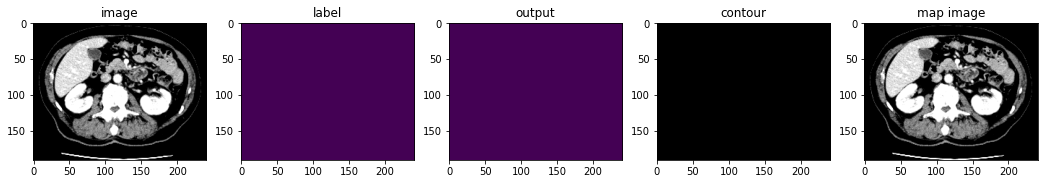

val_dice: tensor([[0.9476]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 206, 239, 241])
Volume: [tensor(57599, device='cuda:0')] mm3


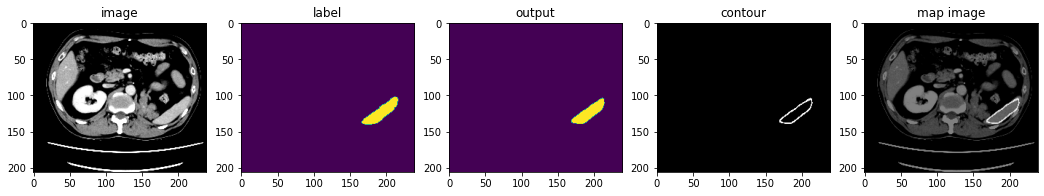

val_dice: tensor([[0.9566]], device='cuda:0')
Hausdorff: tensor([[5.9161]], dtype=torch.float64)
Shape: torch.Size([1, 1, 209, 252, 341])
Volume: [tensor(85932, device='cuda:0')] mm3


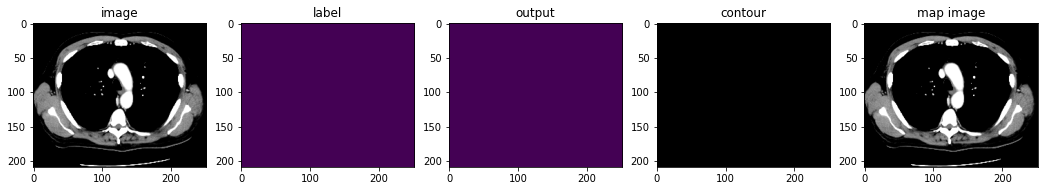

val_dice: tensor([[0.9097]], device='cuda:0')
Hausdorff: tensor([[11.2250]], dtype=torch.float64)
Shape: torch.Size([1, 1, 222, 302, 296])
Volume: [tensor(89392, device='cuda:0')] mm3


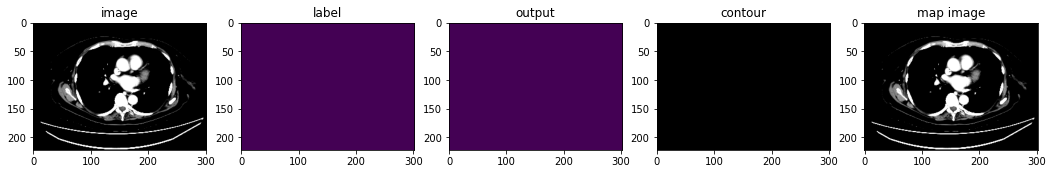

val_dice: tensor([[0.9535]], device='cuda:0')
Hausdorff: tensor([[3.1623]], dtype=torch.float64)
Shape: torch.Size([1, 1, 197, 264, 384])
Volume: [tensor(101376, device='cuda:0')] mm3


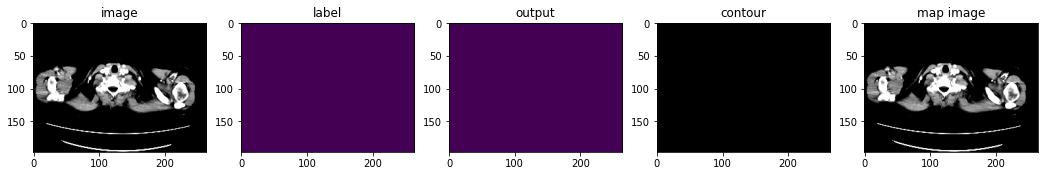

val_dice: tensor([[0.9528]], device='cuda:0')
Hausdorff: tensor([[3.7417]], dtype=torch.float64)
Shape: torch.Size([1, 1, 203, 253, 246])
Volume: [tensor(62238, device='cuda:0')] mm3


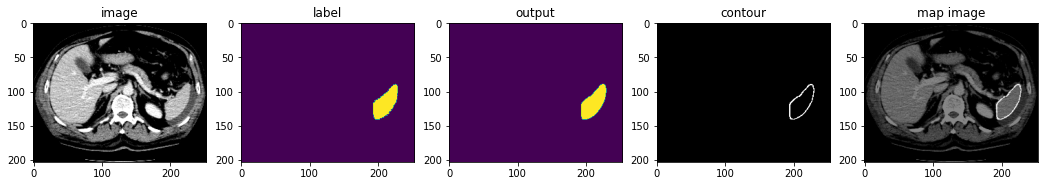

val_dice: tensor([[0.9583]], device='cuda:0')
Hausdorff: tensor([[3.3166]], dtype=torch.float64)
Shape: torch.Size([1, 1, 222, 250, 216])
Volume: [tensor(54000, device='cuda:0')] mm3


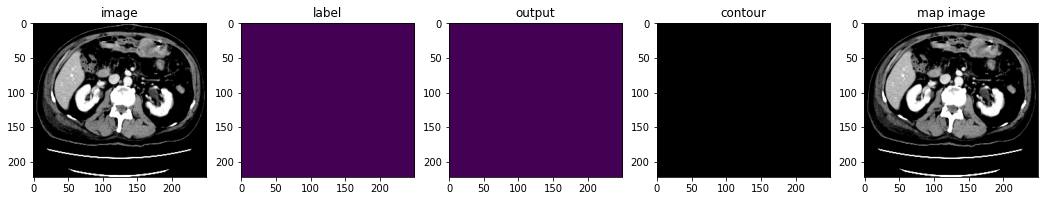

val_dice: tensor([[0.9515]], device='cuda:0')
Hausdorff: tensor([[5.0990]], dtype=torch.float64)
Shape: torch.Size([1, 1, 114, 217, 300])
Volume: [tensor(65100, device='cuda:0')] mm3


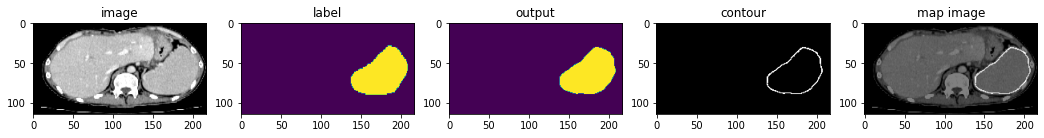

val_dice: tensor([[0.9380]], device='cuda:0')
Hausdorff: tensor([[5.0990]], dtype=torch.float64)
Shape: torch.Size([1, 1, 225, 255, 224])
Volume: [tensor(57120, device='cuda:0')] mm3


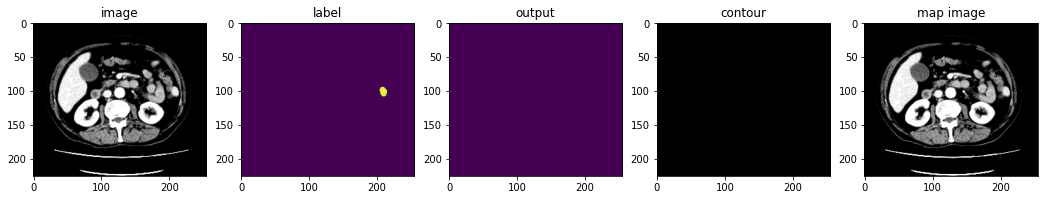

val_dice: tensor([[0.9235]], device='cuda:0')
Hausdorff: tensor([[6.1644]], dtype=torch.float64)
Shape: torch.Size([1, 1, 193, 278, 231])
Volume: [tensor(64218, device='cuda:0')] mm3


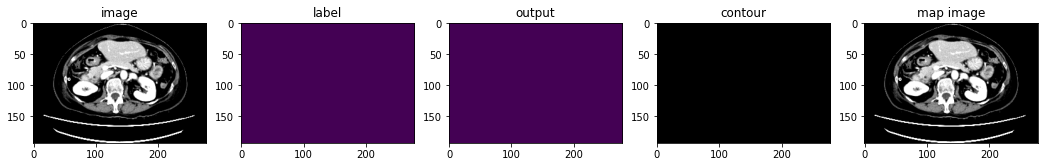

val_dice: tensor([[0.9682]], device='cuda:0')
Hausdorff: tensor([[6.7082]], dtype=torch.float64)
Shape: torch.Size([1, 1, 228, 251, 234])
Volume: [tensor(58734, device='cuda:0')] mm3


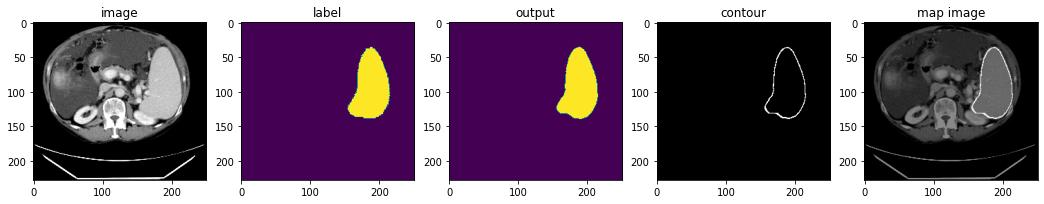

val_dice: tensor([[0.9548]], device='cuda:0')
Hausdorff: tensor([[7.]], dtype=torch.float64)
Shape: torch.Size([1, 1, 211, 252, 278])
Volume: [tensor(70056, device='cuda:0')] mm3


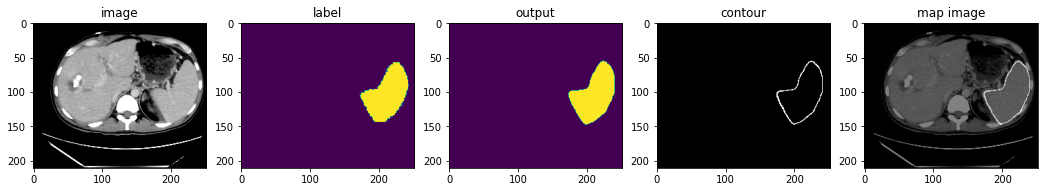

val_dice: tensor([[0.9530]], device='cuda:0')
Hausdorff: tensor([[5.7446]], dtype=torch.float64)
Shape: torch.Size([1, 1, 194, 240, 238])
Volume: [tensor(57120, device='cuda:0')] mm3


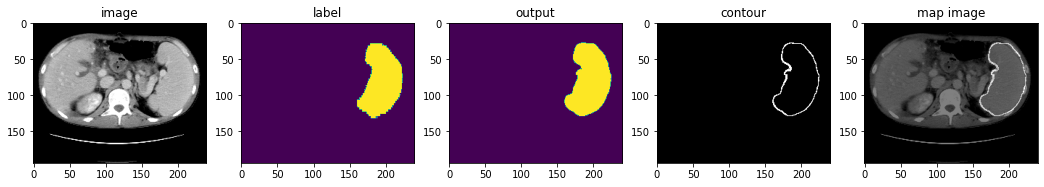

val_dice: tensor([[0.9300]], device='cuda:0')
Hausdorff: tensor([[19.8746]], dtype=torch.float64)
Shape: torch.Size([1, 1, 250, 262, 316])
Volume: [tensor(82792, device='cuda:0')] mm3


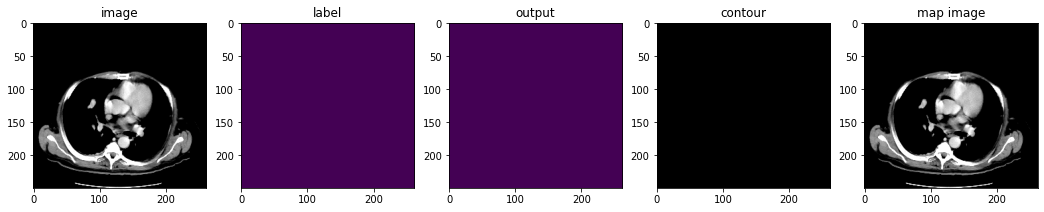

val_dice: tensor([[0.9473]], device='cuda:0')
Hausdorff: tensor([[7.3485]], dtype=torch.float64)
Shape: torch.Size([1, 1, 182, 241, 218])
Volume: [tensor(52538, device='cuda:0')] mm3


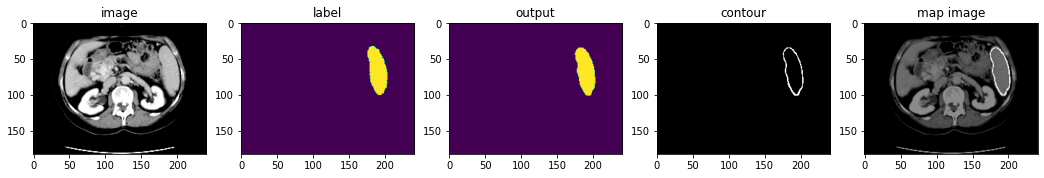

val_dice: tensor([[0.9386]], device='cuda:0')
Hausdorff: tensor([[21.6564]], dtype=torch.float64)
Shape: torch.Size([1, 1, 187, 218, 211])
Volume: [tensor(45998, device='cuda:0')] mm3


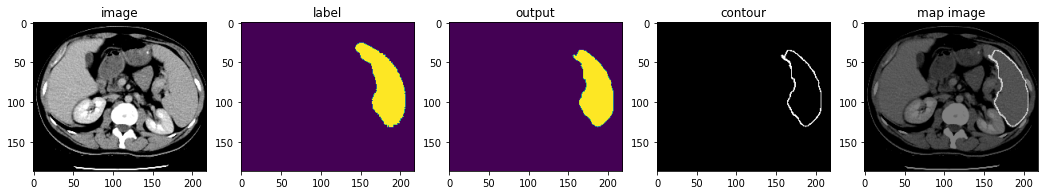

evaluation metric: 0.9414289832115174


In [ ]:
from monai.metrics import get_confusion_matrix, compute_hausdorff_distance
device = torch.device("cuda:0")
model =     UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            ).to(device)
#loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
device = torch.device("cuda:0")
model.load_state_dict(torch.load("/content/drive/My Drive/Task09_Spleen/best_metric_model_ch_500.pth"))
model.eval()
model.to(device)
with torch.no_grad():
        metric_sum = 0.0
        metric_count = 0
        #saver = NiftiSaver(output_dir="./output")
        for val_data in val_loader:
            # define sliding window size and batch size for windows inference
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            val_outputs = post_trans(val_outputs)
            shape=val_images.shape
            vols = [(b[:,1]==1).sum() for b in val_outputs]
            value = compute_meandice(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False)
          
            conf = get_confusion_matrix(y_pred=val_outputs, y=val_labels, include_background=False)
            hausdorff = compute_hausdorff_distance(y_pred=val_outputs, y=val_labels, include_background=False)
            metric_count += len(value)
            metric_sum += value.item() * len(value)
            #print(f"val_loss:", loss)
            print(f"val_dice:", value)
            #print(f"Confusion Matrix:", conf)
            print(f"Hausdorff:",hausdorff)
            print(f"Shape:", shape)
            print(f"Volume:", vols, f"mm3")
            #print(f"y_pred:",val_outputs)
            #print(f"y:", val_labels)
            
            plt.figure("check", (18, 6))
            plt.subplot(1, 5, 1)
            plt.title(f"image")
            plt.imshow(val_data["image"][0, 0, :, :, 65], cmap="gray")
            plt.subplot(1, 5, 2)
            plt.title(f"label")
            plt.imshow(val_data["label"][0, 0, :, :, 65])
            plt.subplot(1, 5, 3)
            plt.title(f"output")
            plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 65])
            plt.subplot(1, 5, 4)
            plt.title(f"contour")
            argmax = AsDiscrete(argmax=True)(val_outputs)
            largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
            contour = LabelToContour()(largest) 
            plt.imshow(contour.detach().cpu()[0, 0, :, :, 65],cmap="gray")
            plt.subplot(1, 5, 5)
            plt.title(f"map image")
            map_image = contour + val_images
            plt.imshow(map_image.detach().cpu()[0, 0, :, :, 65], cmap="gray")
            plt.show()
            
        metric = metric_sum / metric_count
        print("evaluation metric:", metric)